Import Necessary Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
import json
from pandas import json_normalize
from datetime import datetime
from matplotlib.patches import Circle

In [2]:
df = pd.read_csv('flattened_telemetry.csv', sep=',', low_memory=False)
df

,_id,ulCarrierFreq,timestamp,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,...,ulMcs,rssi,cqi,pucchSnr,puschSnr,rnti,dlBytes,phr,pmi_0,pmi_1
0,67c20d2e037f557dd6e2cd3f,3.750240e+09,2025-02-28 19:23:26.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67c20d2f037f557dd6e2cd40,3.750240e+09,2025-02-28 19:23:27.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67c20d30037f557dd6e2cd41,3.750240e+09,2025-02-28 19:23:28.263000064,12345678.0,213.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67c20d31037f557dd6e2cd42,3.750240e+09,2025-02-28 19:23:29.263000064,12345678.0,313.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67c20d32037f557dd6e2cd43,3.750240e+09,2025-02-28 19:23:30.263000064,12345678.0,413.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176428,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,21.5,f0e1,10641.0,61.0,15.0,1.0
176429,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,69.0,6.0,...,6.0,96.0,15.0,15.0,31.0,93aa,24353.0,59.0,0.0,1.0
176430,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,62.0,6.0,...,6.0,62.0,15.0,5.0,3.0,b078,19416.0,52.0,2.0,1.0
176431,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,27.0,f0e1,10786.0,61.0,15.0,1.0


Training DATA Analysis

In [3]:
df.shape # size of the training data (#rows, #features)

(176433, 29)

In [4]:
df.dropna(inplace = True) # dropping NaN Values i.e removing all empty noisy data
df.shape # size after removing NaN values

(168861, 29)

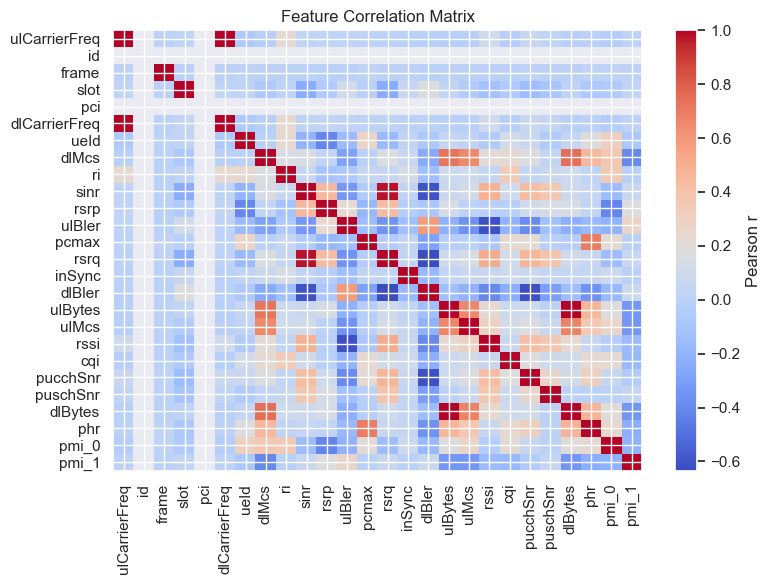

In [5]:
#Analysing the correlation between features (Only Numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols] .corr()
scaler = StandardScaler()
df1 = pd.DataFrame()
df1[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Removing 2% of outliers/Noisy data using Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df['iforest_label'] = iso.fit_predict(df[numeric_cols])
# label = −1 is an outlier
n_iso = (df['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df):.2%})")

IsolationForest outliers: 1689 (1.00%)


In [7]:
df = df[df['iforest_label'] == 1].reset_index(drop=True) #keeping only inliners
df.drop(columns=['iforest_label'], inplace=True)

In [8]:
df.describe()

,ulCarrierFreq,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,ri,sinr,...,ulBytes,ulMcs,rssi,cqi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1
count,1.671720e+05,167172.0,167172.000000,167172.000000,167172.0,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,...,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,167172.000000,1.671720e+05,167172.000000,167172.000000,167172.000000
mean,3.750306e+09,12345678.0,509.845471,10.709515,0.0,3.750306e+09,22.580516,10.139832,1.932644,21.165294,...,1.467366e+09,7.372090,77.384429,14.520045,14.363141,15.321190,6.683665e+08,53.555775,8.591182,0.597768
std,1.404990e+06,0.0,295.017824,6.528031,0.0,1.404990e+06,10.364159,7.632047,0.268342,7.940488,...,4.395379e+09,2.707526,6.998459,1.805117,5.032339,7.566763,1.814033e+09,7.887585,5.979025,0.545379
min,3.750240e+09,12345678.0,0.000000,2.000000,0.0,3.750240e+09,1.000000,0.000000,1.000000,-10.000000,...,0.000000e+00,0.000000,59.800000,1.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3.750240e+09,12345678.0,254.000000,4.000000,0.0,3.750240e+09,20.000000,6.000000,2.000000,23.500000,...,1.259912e+06,6.000000,75.000000,15.000000,13.000000,12.000000,4.649668e+05,52.000000,0.000000,0.000000
50%,3.750240e+09,12345678.0,507.000000,9.000000,0.0,3.750240e+09,22.000000,9.000000,2.000000,23.500000,...,8.041060e+06,6.000000,79.900000,15.000000,15.000000,16.000000,2.219774e+06,52.000000,11.000000,1.000000
75%,3.750240e+09,12345678.0,766.000000,19.000000,0.0,3.750240e+09,24.000000,9.000000,2.000000,23.500000,...,3.637968e+07,8.000000,81.500000,15.000000,16.000000,18.000000,1.211683e+08,52.000000,13.000000,1.000000
max,3.780300e+09,12345678.0,1023.000000,19.000000,0.0,3.780300e+09,69.000000,27.000000,4.000000,23.500000,...,2.275132e+10,27.000000,120.000000,15.000000,60.000000,63.500000,9.106684e+09,65.000000,15.000000,3.000000


In [9]:
#features in the data
df.columns

Index(['_id', 'ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', 'ueId', 'dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler',
       'pcmax', 'rsrq', 'inSync', 'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'cqi',
       'pucchSnr', 'puschSnr', 'rnti', 'dlBytes', 'phr', 'pmi_0', 'pmi_1'],
      dtype='object')

Considering the following features for user signature:
'rnti'
'rsrp'
'pucchSnr'
'rssi'
'ulBler'
'puschSnr'
'dlBler'
'rsrq'
'sinr'


In [10]:
to_drop = [
    '_id', 'id', 'ueId',  'cqi',    # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df = df.drop(columns=to_drop, errors='ignore')

df.columns

Index(['sinr', 'rsrp', 'ulBler', 'rsrq', 'dlBler', 'rssi', 'pucchSnr',
       'puschSnr', 'rnti'],
      dtype='object')

In [11]:
df.head()

,sinr,rsrp,ulBler,rsrq,dlBler,rssi,pucchSnr,puschSnr,rnti
0,12.0,-89.0,0.169858,-11.0,0.065610,100.3,40.0,34.0,b39a
1,11.5,-89.0,0.275585,-11.0,0.059049,86.0,38.0,21.5,b39a
2,11.5,-89.0,0.444611,-11.0,0.047830,83.7,39.0,16.5,b39a
3,11.5,-89.0,0.397827,-11.0,0.038742,82.4,35.0,15.0,b39a
4,11.5,-89.0,0.396927,-11.0,0.031381,82.6,32.0,15.0,b39a


In [12]:
raw_cols = ['sinr','rsrp','rssi','pucchSnr','puschSnr','ulBler','dlBler','rsrq']
scaler_raw = StandardScaler() # Normalise
df_scaled = pd.DataFrame() # A new DataFrame to work on
df_scaled[raw_cols] = scaler_raw.fit_transform(df[raw_cols])


In [13]:
df_scaled['rnti']= df['rnti'] 

In [14]:
df_scaled.head()

,sinr,rsrp,rssi,pucchSnr,puschSnr,ulBler,dlBler,rsrq,rnti
0,-1.154252,-1.362237,3.274384,5.094437,2.468541,-0.466089,-0.236657,0.0823,b39a
1,-1.217220,-1.362237,1.231071,4.697006,0.816575,-0.221125,-0.256792,0.0823,b39a
2,-1.217220,-1.362237,0.902426,4.895722,0.155788,0.170499,-0.291221,0.0823,b39a
3,-1.217220,-1.362237,0.716670,4.100860,-0.042448,0.062103,-0.319111,0.0823,b39a
4,-1.217220,-1.362237,0.745248,3.504714,-0.042448,0.060018,-0.341701,0.0823,b39a


CREATING TIME WINDOWED SEQUENCES for each window: the mean of the features and their corresponding correalations are captured

In [15]:

def extract_phy_signatures(df_scaled,
                           raw_features=None,
                           window_size=50,
                           step_size=50,
                           label_col=None):
    """
    Slide a window over df and for each window compute:
      - mean of each raw_feature
      - Pearson correlation of every pair of raw_features

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed, timestamp-sorted DataFrame of physical-layer columns.
    raw_features : list of str, optional
        Columns to treat as the base attributes. If None, defaults to:
        ['sinr','rsrp','rssi','cqi','pucchSnr','puschSnr','ulBler','dlBler']
    window_size : int
        Number of rows per window.
    step_size : int
        Sliding step between windows (use ==window_size for non-overlap).
    label_col : str, optional
        Name of a column (e.g. 'rnti' or 'ueId') whose mode in each window
        will be returned as the true label for that signature.

    Returns
    -------
    sig_df : pd.DataFrame
        Each row is a signature: [mean_{f1} … mean_{fD}, corr_{f1,f2} …]
    labels : list, only if label_col is set
        The mode of `label_col` in each window, in the same order as sig_df.
    """
    if raw_features is None:
        raw_features = [
            'sinr', 'rsrp', 'rssi','rsrq',
            'pucchSnr', 'puschSnr', 'ulBler', 'dlBler'
        ]

    D = len(raw_features)
    # build column names
    corr_pairs = [(i, j) for i in range(D) for j in range(i+1, D)]
    col_names = ([f"mean_{f}" for f in raw_features] +
                [f"corr_{raw_features[i]}_{raw_features[j]}" 
                   for i,j in corr_pairs])

    signatures = []
    labels = []  # only used if label_col is provided

    for start in range(0, len(df_scaled) - window_size + 1, step_size):
        w = df_scaled.iloc[start:start+window_size]

        # 1) raw means
        means = w[raw_features].mean().values

        # 2) correlations
        cmat = w[raw_features].corr().values
        iu = np.triu_indices(D, k=1)
        corr_vals = cmat[iu]

        signatures.append(np.concatenate([means, corr_vals]))
        #signatures.append(means)
        # 3) window label (mode of label_col)
        if label_col is not None:
            labels.append(w[label_col].mode()[0])

    sig_df = pd.DataFrame(signatures, columns=col_names)
    if label_col is not None:
        return sig_df, labels
    return sig_df


# ----------------------------
# Example usage:



# 2) Get signatures *and* the per-window RNTI mode



In [16]:
sig_df, window_rntis = extract_phy_signatures(
    df_scaled,
    window_size=100,
    step_size=100,
    label_col='rnti'
)

In [17]:
sig_df = df_scaled.copy()

In [18]:
sig_df.columns

Index(['sinr', 'rsrp', 'rssi', 'pucchSnr', 'puschSnr', 'ulBler', 'dlBler',
       'rsrq', 'rnti'],
      dtype='object')

In [19]:
sig_df.describe()

,sinr,rsrp,rssi,pucchSnr,puschSnr,ulBler,dlBler,rsrq
count,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05,1.671720e+05
mean,1.526733e-16,-2.176189e-16,-1.479809e-15,-9.520827e-17,3.332290e-17,4.352378e-17,-9.928863e-17,1.679746e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-3.924871e+00,-4.100532e+00,-2.512622e+00,-2.258030e+00,-2.024807e+00,-8.596406e-01,-4.380053e-01,-4.462672e+00
25%,2.940264e-01,-5.407482e-01,-3.407088e-01,-2.708770e-01,-4.389195e-01,-8.589779e-01,-4.380053e-01,2.799073e-01
50%,2.940264e-01,6.910766e-03,3.594475e-01,1.265537e-01,8.970968e-02,-6.098263e-01,-4.379992e-01,2.799073e-01
75%,2.940264e-01,8.283992e-01,5.880699e-01,3.252690e-01,3.540243e-01,1.456914e+00,-3.316253e-01,2.799073e-01
max,2.940264e-01,3.155950e+00,6.089297e+00,9.068744e+00,6.367182e+00,1.538399e+00,2.690684e+00,2.799073e-01


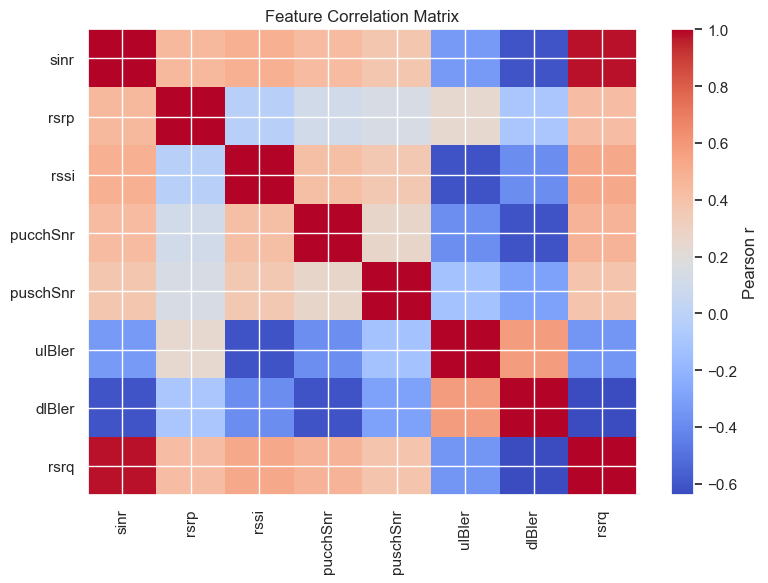

In [20]:

numeric_cols = sig_df.select_dtypes(include=[np.number]).columns.tolist()
corr = sig_df[numeric_cols].corr()
scaler = StandardScaler()
df_c = pd.DataFrame()
df_c[numeric_cols] = scaler.fit_transform(sig_df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [21]:
constant_cols = [col for col in numeric_cols if sig_df[col].nunique() <= 1]
print("Constant columns:", constant_cols)

Constant columns: []


In [22]:
# Get average absolute correlation of each feature with others
mean_corr = corr.abs().mean().sort_values()

print("Features with lowest mean correlation:")
print(mean_corr.head(10))


Features with lowest mean correlation:
rsrp        0.308638
puschSnr    0.365046
ulBler      0.450253
pucchSnr    0.459246
rssi        0.475356
dlBler      0.526142
sinr        0.581643
rsrq        0.595878
dtype: float64


In [23]:
low_corr_pairs = []
for col in corr.columns:
    for row in corr.index:
        if col != row and abs(corr.loc[row, col]) < 0.05:
            low_corr_pairs.append((row, col, corr.loc[row, col]))

# View top 10 uncorrelated pairs
print("Low-correlation feature pairs:")
for a, b, val in low_corr_pairs[:10]:
    print(f"{a} vs {b}: r = {val:.2f}")


Low-correlation feature pairs:
rssi vs rsrp: r = -0.02
rsrp vs rssi: r = -0.02


In [24]:
sig_df.columns

Index(['sinr', 'rsrp', 'rssi', 'pucchSnr', 'puschSnr', 'ulBler', 'dlBler',
       'rsrq', 'rnti'],
      dtype='object')

In [25]:
n_total = len(sig_df)

# number of windows with any NaN
n_with_nan = sig_df.isna().any(axis=1).sum()

print(f"{n_with_nan} out of {n_total} windows ({n_with_nan/n_total:.1%}) have at least one NaN")

0 out of 167172 windows (0.0%) have at least one NaN


In [26]:
nan_per_col = sig_df.isna().sum().sort_values(ascending=False)
print(nan_per_col)

sinr        0
rsrp        0
rssi        0
pucchSnr    0
puschSnr    0
ulBler      0
dlBler      0
rsrq        0
rnti        0
dtype: int64


In [27]:
sig_df = sig_df.fillna(0)
sig_df

,sinr,rsrp,rssi,pucchSnr,puschSnr,ulBler,dlBler,rsrq,rnti
0,-1.154252,-1.362237,3.274384,5.094437,2.468541,-0.466089,-0.236657,0.082300,b39a
1,-1.217220,-1.362237,1.231071,4.697006,0.816575,-0.221125,-0.256792,0.082300,b39a
2,-1.217220,-1.362237,0.902426,4.895722,0.155788,0.170499,-0.291221,0.082300,b39a
3,-1.217220,-1.362237,0.716670,4.100860,-0.042448,0.062103,-0.319111,0.082300,b39a
4,-1.217220,-1.362237,0.745248,3.504714,-0.042448,0.060018,-0.341701,0.082300,b39a
...,...,...,...,...,...,...,...,...,...
167167,-0.713471,-2.594469,-2.198266,-1.860600,-1.628335,1.457306,2.615981,0.082300,b078
167168,-2.224718,-2.594469,-0.112086,0.523984,-0.042448,1.441931,-0.051887,-0.905737,93aa
167169,-0.713471,-2.594469,-2.198266,-1.860600,-1.628335,1.457306,2.615981,0.082300,b078
167170,-2.224718,-2.594469,2.659961,0.126554,2.072069,1.451944,-0.090499,-0.905737,93aa


In [28]:
#nan_frac = sig_df.isna().mean()

# 2. Choose a threshold (e.g. 0.5 for 50%)
#threshold = 0.5

# 3. Identify columns to drop vs keep
#drop_cols = nan_frac[nan_frac > threshold].index.tolist()
#keep_cols = nan_frac[n0.an_frac <= threshold].index.tolist()

#print(f"Dropping {len(drop_cols)} columns with >{threshold*100:.0f}% NaNs:")
#print(drop_cols)
#print(f"\nKeeping {len(keep_cols)} columns with ≤{threshold*100:.0f}% NaNs:")
#print(keep_cols)

In [29]:
#sig_df.drop(columns= drop_cols, inplace = True)

In [30]:
#sig_df.dropna(inplace = True)

In [31]:
sig_df.columns

Index(['sinr', 'rsrp', 'rssi', 'pucchSnr', 'puschSnr', 'ulBler', 'dlBler',
       'rsrq', 'rnti'],
      dtype='object')

APPLY K-Means CLustering on whole data to determine the number of clusters

In [32]:
X = sig_df.drop(columns = 'rnti').values
best_k = 2
# 2. Fit final k-means
km_final = KMeans(n_clusters=best_k, random_state=0, init='k-means++').fit(X)
labels   = km_final.labels_
centroids= km_final.cluster_centers_

# 3. Attach back to your sig_df
sig_df['kmeans_label'] = labels

PCA PROJECTION TO VISUALISE THE CLUSTERS ON 2 PRINCIPLE COMPONENTS

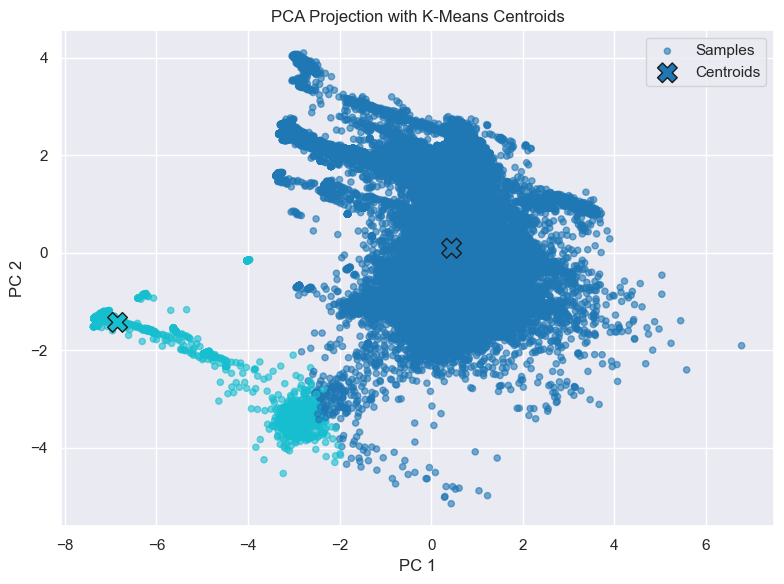

In [33]:
labels = sig_df['kmeans_label'].values        # or 'dbscan_label'

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Project centroids into the same PCA space
centroids = km_final.cluster_centers_               # shape (K, n_features)
centroids_pca = pca.transform(centroids)      # shape (K, 2)

# 3. Scatter plot of windows
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels,
    cmap='tab10',
    s=20,
    alpha=0.6,
    label="Samples"
)

# 4. Overlay centroids
plt.scatter(
    centroids_pca[:,0], centroids_pca[:,1],
    c=range(len(centroids_pca)),
    cmap='tab10',
    marker='X',
    s=200,
    edgecolor='k',
    label="Centroids"
)

plt.legend(loc='best')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection with K-Means Centroids")
plt.tight_layout()
plt.show()


TSNE : NON LINEAR PROJECTION ON 2 COMPOENTNS

TESTING ON NEW DATA(AUTHENTIC AND NON-AUTHENTIC): READ the DATA FILES THAT You want to test on

In [ ]:
#preprocessing test data

In [34]:
#authentic_1_noise_less_antennas.csv
#authentic_2_normal.csv
#authentic_3_obstacles.csv
#non_authentic_1_diff_position.csv
#non_authentic_2_less_antennas_diff_position.csv
#non_authentic_3_no_antennas.csv

In [36]:
df1 = pd.read_csv('non_authentic_2_less_antennas_diff_position.csv', sep=',', low_memory=False) # read the testing data files

In [37]:
df1.columns

Index(['ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', '_id.$oid', 'avgLdpcIterations', 'rnti', 'ulBytes',
       'pmi', 'rsrp', 'cqi', 'pucchSnr', 'rssi', 'ueId', 'inSync', 'dlBytes',
       'dlMcs', 'ulMcs', 'ulBler', 'ri', 'pcmax', 'puschSnr', 'dlBler', 'phr',
       'rsrq', 'sinr'],
      dtype='object')

In [38]:
#drop the Nan values and remove outliers using Isolation Forest

In [39]:
df1.dropna(inplace = True)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df1['iforest_label'] = iso.fit_predict(df1[numeric_cols])
# label = −1 is an outlier
n_iso = (df1['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df1):.2%})")
df1 = df1[df1['iforest_label'] == 1].reset_index(drop=True)
df1.drop(columns=['iforest_label'], inplace=True)

IsolationForest outliers: 205 (1.00%)


In [40]:
#Keep the features same as training data

to_drop = [
    '_id', 'id', 'ueId',  'cqi', '_id.$oid', 'avgLdpcIterations', 'pmi',  # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df1 = df1.drop(columns=to_drop, errors='ignore')

print(df1.columns)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler() # Normalise using StandardSCALER
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])
print(df1.head())

Index(['rnti', 'rsrp', 'pucchSnr', 'rssi', 'ulBler', 'puschSnr', 'dlBler',
       'rsrq', 'sinr'],
      dtype='object')
   rnti      rsrp  pucchSnr      rssi    ulBler  puschSnr    dlBler      rsrq  \
0  ff31 -0.404623  0.954570  1.079373 -0.925519  0.226671 -0.978044  0.263309   
1  ff31 -0.404623 -0.206713  1.573837 -1.050969  0.776832 -0.898519  0.263309   
2  ff31 -0.404623  0.606185  0.692401 -0.148591 -0.002563 -0.857509  0.263309   
3  ff31 -0.330526  0.373928  1.423348  0.398923  0.593445 -0.895760  0.263309   
4  ff31 -0.330526  0.373928  1.358852  0.369591  0.455905 -0.739063  0.263309   

       sinr  
0 -0.092936  
1 -0.092936  
2 -0.092936  
3 -0.092936  
4 -0.034796  


In [41]:
#prepare the time windowed sequences for test data
sig_df_test = df1.copy()

In [42]:

sig_df_test.columns

Index(['rnti', 'rsrp', 'pucchSnr', 'rssi', 'ulBler', 'puschSnr', 'dlBler',
       'rsrq', 'sinr'],
      dtype='object')

In [43]:
print(X)

[[-1.15425168 -1.36223669  3.27438358 ... -0.4660887  -0.23665689
   0.0822998 ]
 [-1.2172203  -1.36223669  1.23107052 ... -0.22112492 -0.25679173
   0.0822998 ]
 [-1.2172203  -1.36223669  0.90242576 ...  0.17049926 -0.29122136
   0.0822998 ]
 ...
 [-0.71347139 -2.5944694  -2.1982661  ...  1.45730576  2.61598144
   0.0822998 ]
 [-2.22471811 -2.5944694   2.65996077 ...  1.45194435 -0.090499
  -0.90573748]
 [-0.71347139 -2.5944694  -2.1982661  ...  1.45730576  2.61598144
   0.0822998 ]]


In [44]:
#Evaluate the performance
sig_df.columns

Index(['sinr', 'rsrp', 'rssi', 'pucchSnr', 'puschSnr', 'ulBler', 'dlBler',
       'rsrq', 'rnti', 'kmeans_label'],
      dtype='object')

In [45]:
from sklearn.metrics import pairwise_distances

X = sig_df.drop(columns=['rnti','kmeans_label'], errors='ignore').values
X_new = sig_df_test.drop(columns='rnti', errors='ignore').values
print(X.shape)
print(X_new.shape)
# Train labels and assigned cluster distances
print(km_final.cluster_centers_.shape)
train_labels = km_final.labels_
train_dists = pairwise_distances(X, km_final.cluster_centers_)
train_assigned_dists = np.array([
    train_dists[i, label] for i, label in enumerate(train_labels)
])

# Per-cluster threshold
cluster_thresholds = {}
for k in range(km_final.n_clusters):
    dists_k = train_assigned_dists[train_labels == k]
    cluster_thresholds[k] = np.percentile(dists_k, 95)

# Predict on new data
new_labels = km_final.predict(X_new)
test_dists = pairwise_distances(X_new, km_final.cluster_centers_)

# Distances to assigned centroid
sig_df_test['new_dists'] = np.array([
    test_dists[i, new_labels[i]] for i in range(len(new_labels))
])

# Label based on distance to assigned cluster centroid
sig_df_test['authenticity'] = [
    'authentic' if sig_df_test['new_dists'][i] <= cluster_thresholds[new_labels[i]] else 'non_authentic'
    for i in range(len(new_labels))
]

(167172, 8)
(20231, 8)
(2, 8)


In [46]:
cluster_thresholds

{0: 4.358882893195423, 1: 5.106610282598457}

In [47]:
sig_df_test

,rnti,rsrp,pucchSnr,rssi,ulBler,puschSnr,dlBler,rsrq,sinr,new_dists,authenticity
0,ff31,-0.404623,0.954570,1.079373,-0.925519,0.226671,-0.978044,0.263309,-0.092936,2.056459,authentic
1,ff31,-0.404623,-0.206713,1.573837,-1.050969,0.776832,-0.898519,0.263309,-0.092936,2.317593,authentic
2,ff31,-0.404623,0.606185,0.692401,-0.148591,-0.002563,-0.857509,0.263309,-0.092936,1.398001,authentic
3,ff31,-0.330526,0.373928,1.423348,0.398923,0.593445,-0.895760,0.263309,-0.092936,1.826803,authentic
4,ff31,-0.330526,0.373928,1.358852,0.369591,0.455905,-0.739063,0.263309,-0.034796,1.666416,authentic
...,...,...,...,...,...,...,...,...,...,...,...
20226,308f,-1.886576,-1.019611,-0.662000,0.692030,-0.873652,0.962219,-4.056586,-2.476688,5.609884,non_authentic
20227,6695,-0.478721,0.257800,1.079373,0.502136,0.272518,-1.058835,0.263309,-0.151077,1.703357,authentic
20228,30be,1.670111,0.257800,0.885887,-1.518821,0.455905,-1.058818,0.551302,1.069869,2.745961,authentic
20229,23b3,0.484548,0.141672,0.799893,0.692030,0.547598,-1.009345,0.263309,0.488466,1.454638,authentic


In [48]:
print(sig_df_test['authenticity'].value_counts())

authenticity
authentic        19363
non_authentic      868
Name: count, dtype: int64


In [49]:
explained_var = pca.explained_variance_ratio_
total_var = explained_var.sum()
print(total_var)

0.6737376792375757


In [50]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # X from your training data
centroids_pca = pca.transform(km_final.cluster_centers_)

In [51]:
X_new_pca = pca.transform(X_new)

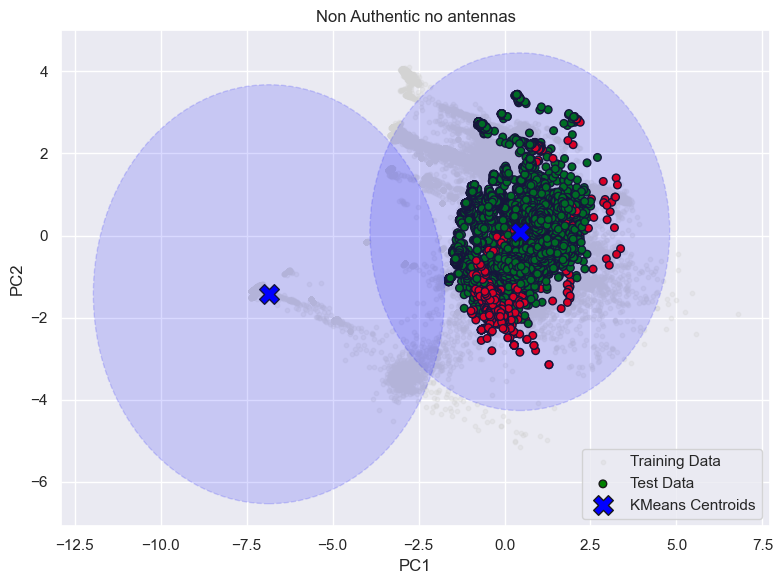

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot training data (light gray background)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.3, label='Training Data')

# Plot new test data points
color_map = {'authentic': 'green', 'non_authentic': 'red'}
colors = sig_df_test['authenticity'].map(color_map)

plt.scatter(X_new_pca[:, 0], X_new_pca[:, 1], c=colors, s=30, edgecolor='k', label='Test Data')

# Overlay centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='blue', marker='X', s=200, edgecolor='k', label='KMeans Centroids'
)
for i, (cx, cy) in enumerate(centroids_pca):
    # Use per-cluster threshold if available; otherwise fallback to global
    radius = cluster_thresholds.get(i)
    
    # Optional: transform the threshold radius into PCA space — approximate by applying PCA to vector with that magnitude
    #unit_vec = km_final.cluster_centers_[i] + radius * np.ones(km_final.cluster_centers_.shape[1])
    #transformed_vec = pca.transform([unit_vec])[0]
    #scaled_radius = ((transformed_vec - centroids_pca[i])**2).sum()**0.5

    circle = Circle((cx, cy), radius, color='blue', alpha=0.15, linestyle='--', linewidth=1, fill=True)
    plt.gca().add_patch(circle)

plt.title('Non Authentic no antennas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()